In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import re
from collections import defaultdict


from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision
import torchvision.transforms.functional as FT

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt
from torchvision.ops.boxes import box_iou

DIR_INPUT = '/media/jake/mark-4tb3/input/kaggle_4tb/global-wheat-detection'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'
%load_ext autotime

In [2]:
train_df = pd.read_csv(f'{DIR_INPUT}/train.csv')
train_df.shape

(147793, 5)

time: 106 ms


In [3]:
train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df.drop(columns=['bbox'], inplace=True)
train_df['x'] = train_df['x'].astype(np.float)
train_df['y'] = train_df['y'].astype(np.float)
train_df['w'] = train_df['w'].astype(np.float)
train_df['h'] = train_df['h'].astype(np.float)

time: 891 ms


In [4]:
image_ids = train_df['image_id'].unique()
valid_num = -20
valid_ids = image_ids[valid_num:]
train_ids = image_ids[:valid_num]

time: 4.41 ms


In [5]:
image_ids = train_df['image_id'].unique()
valid_num = -20
valid_ids = image_ids[valid_num:]
train_ids = image_ids[:valid_num]

time: 20.6 ms


In [6]:
valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]

time: 14.1 ms


In [7]:
valid_df.shape, train_df.shape

((423, 8), (147370, 8))

time: 2.53 ms


In [8]:
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], valid_loss_min.item()

time: 974 µs


In [9]:
PATH = '/media/jake/mark-4tb3/input/kaggle_4tb/global-wheat-detection/weights/weat.pth'
weight_path = '/media/jake/mark-4tb3/input/kaggle_4tb/global-wheat-detection/results/bestmodel_may12.pt'
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

#model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
#checkpoint = torch.load(weight_path)
#print(checkpoint)
#model.load_state_dict(checkpoint['state_dict'])

model.load_state_dict(torch.load(PATH))
model.cuda().eval()

cpu_device = torch.device("cpu")

device= 'cuda'
sample_num = 1

time: 1.97 s


In [10]:
class WheatDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        #print('boxesA->',boxes)
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            #print('image->',image.shape,type(image))
            #print('target-boxes->',target['boxes'])
            
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

time: 3.49 ms


In [11]:
# Albumentations
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


time: 17.5 ms


In [12]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = WheatDataset(train_df, DIR_TRAIN, get_train_transform())
valid_dataset = WheatDataset(valid_df, DIR_TRAIN, get_valid_transform())


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

time: 7.56 ms


In [13]:
images, targets, image_ids = next(iter(valid_data_loader))

time: 391 ms


In [14]:
images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

time: 30.3 ms


In [15]:
boxes_true = targets[sample_num]['boxes'].cpu().numpy().astype(np.int32)
sample = images[sample_num].permute(1,2,0).cpu().numpy()

time: 4.59 ms


In [16]:
image = images[sample_num]

time: 523 µs


In [17]:
model.eval()
cpu_device = torch.device("cpu")

outputs = model([image])
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

time: 59.8 ms


/home/jake/venv/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


In [18]:
[output['boxes'].tolist() for output in outputs]

[[]]

time: 2.38 ms


In [19]:
boxes_true

array([[   0,   81,  133,  171],
       [ 588,  373,  704,  496],
       [ 527,  114,  691,  226],
       [ 637,    0,  757,   61],
       [ 240,  145,  335,  250],
       [   0,    0,  120,   64],
       [   0,  243,   89,  322],
       [   0,  752,   74,  847],
       [ 839,  862,  924,  936],
       [ 427,  878,  547,  993],
       [ 829,  757,  934,  834],
       [ 904,  118, 1005,  206],
       [ 347,  656,  450,  728],
       [ 450,  373,  542,  455]], dtype=int32)

time: 2.77 ms


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


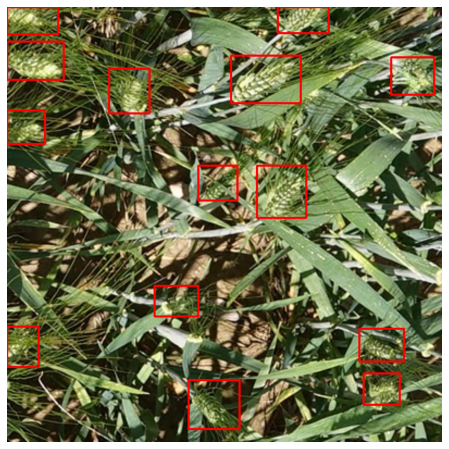

time: 238 ms


In [20]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes_true:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)